In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import re
from textblob import TextBlob
from time import time
from sklearn.metrics import f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
'''
https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0
https://towardsdatascience.com/feature-engineering-in-python-part-i-the-most-powerful-way-of-dealing-with-data-8e2447e7c69e
https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
'''

'\nhttps://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e\nhttps://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0\nhttps://towardsdatascience.com/feature-engineering-in-python-part-i-the-most-powerful-way-of-dealing-with-data-8e2447e7c69e\n'

In [2]:
test = pd.read_csv("./loansTest.csv")
train = pd.read_csv("./loansTrain.csv")

In [3]:
# extract feature columns
feature_cols = list(train.columns[:-1])
# extract target column 'loan_status'
target_col = train.columns[-1]

# separate the data into feature data and target data
X_all = train[feature_cols]
y_all = train[target_col]

# extract feature columns
feature_cols = list(test.columns[1:])
# extract target column 'loan_status'
target_col = test.columns[0]

# separate the data into feature data and target data
X_test = test[feature_cols]
id_test = test[target_col]

X_all = pd.concat([X_all, X_test], ignore_index=True, sort=False)

In [4]:
def preprocess_features(X):
    ''' Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        print(col)
        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

# Feature Engineering

In [ ]:
toBeTransform = ['emp_length','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mths_since_recent_bc','mths_since_recent_inq']
# to help normalizing the magnitude diffrences in time related features
for t in toBeTransform:
    X_all[t] = (data[t]+1).transform(np.log)


We notice that it contains categorical values. After using X_all['emp_title'].unique() , we notice that the values of the emp_title are repeated in a way. So we are trying to combine repeated values.

In [5]:
# all missing values unemployed
X_all['emp_title'].fillna("unemployed",inplace=True)

# all titles lower case
X_all['emp_title'].str.lower()

# Replace non-alphanumeric
X_all['emp_title'] = X_all['emp_title'].astype(str).replace('[^a-zA-Z0-9 ]', '', regex=True)

# fix spelling mistakes
#X_all['emp_title'].apply(lambda txt: ''.join(TextBlob(txt).correct()))

frequent_titles = pd.Series(' '.join(X_all['emp_title']).lower().split()).value_counts()[:200]
arr = frequent_titles.index.to_numpy()

to_be_ignored = ['the', 'of', 'and', '&', 'city', '-', '/','sr.', 'sr','inc.']

for ingnore in to_be_ignored:
    arr = np.delete(arr, np.argwhere(arr == ingnore))

# Feature Transformation

whole = '|'.join(arr)
arr = map(lambda x:[x, re.compile('.*'+ x +'.*')], arr )

for r in arr:
    print('.',end="")
    X_all['emp_title'] = X_all['emp_title'].str.replace(r[1], r[0], regex=True)
    
# renaming everything else to 'other'
X_all['emp_title'] = np.where(~X_all['emp_title'].str.contains(whole), 'other', X_all['emp_title'])


#Dropping columns with missing value rate higher than threshold
X_all = X_all[X_all.columns[X_all.isnull().mean() < 0.7]]

# replace null with zeros
for col in X_all.columns:
    # Replacing the missing values with the maximum occurred value 
    X_all[col].fillna(X_all[col].value_counts().idxmax(), inplace=True)
    #X_all[col].fillna(0,inplace=True) 
    
    # removing trailing whitespaces and making all lowercase
    if X_all[col].type == np.object:
        X_all[col].str.strip()
        X_all[col].str.lower()
    


['manager', re.compile('.*manager.*')]
['unemployed', re.compile('.*unemployed.*')]
['director', re.compile('.*director.*')]
['sales', re.compile('.*sales.*')]
['assistant', re.compile('.*assistant.*')]
['supervisor', re.compile('.*supervisor.*')]
['specialist', re.compile('.*specialist.*')]
['teacher', re.compile('.*teacher.*')]
['engineer', re.compile('.*engineer.*')]
['analyst', re.compile('.*analyst.*')]
['senior', re.compile('.*senior.*')]
['driver', re.compile('.*driver.*')]
['service', re.compile('.*service.*')]
['nurse', re.compile('.*nurse.*')]
['officer', re.compile('.*officer.*')]
['technician', re.compile('.*technician.*')]
['tech', re.compile('.*tech.*')]
['coordinator', re.compile('.*coordinator.*')]
['owner', re.compile('.*owner.*')]
['operations', re.compile('.*operations.*')]
['operator', re.compile('.*operator.*')]
['project', re.compile('.*project.*')]
['associate', re.compile('.*associate.*')]
['office', re.compile('.*office.*')]
['registered', re.compile('.*registe

In [6]:
len(X_all['emp_title'].unique())

143

In [7]:
# feature removel
X_all.drop(['zip_code', 'addr_state', 'earliest_cr_line'], axis=1, inplace=True)
# feature removel
# X_all.drop(['zip_code', 'dti', 'avg_cur_bal','application_type','emp_title','chargeoff_within_12_mths','acc_now_delinq', 'delinq_amnt','percent_bc_gt_75','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','tax_liens'], axis=1, inplace=True)

In [8]:
# Convert categorical variable into dummy/indicator variables
X_all['term'] = X_all['term'].replace(['36 months', '60 months'], [0, 1])
X_all['verification_status'] = pd.get_dummies(X_all['verification_status'], prefix = 'verification_status')  
X_all['purpose'] = pd.get_dummies(X_all['purpose'], prefix = 'purpose')  
X_all['application_type'] = pd.get_dummies(X_all['application_type'], prefix = 'application_type')  
X_all['emp_title'] = pd.get_dummies(X_all['emp_title'], prefix = 'emp_title')  


# X_all = preprocess_features(X_all)
X, X_test = X_all.iloc[:1000000,:], X_all.iloc[1000000:,:]
X_train, X_val, y_train, y_val = train_test_split(X, y_all, train_size=0.95, random_state=1)

loan_amnt
term
grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
purpose
dti
delinq_2yrs
inq_last_6mths
open_acc
pub_rec
revol_bal
revol_util
collections_12_mths_ex_med
application_type
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_rev_hi_lim
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_inq
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_accts
num_rev_tl_bal_gt_0
num_sats
num_tl_120dpd_2m
num_tl_30dpd
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
percent_bc_gt_75
pub_rec_bankruptcies
tax_liens
tot_hi_cred_lim
total_bal_ex_mort
total_il_high_credit_limit


# Univariate Selection
Statistical tests can be used to select those features that have the strongest relationship with the output variable. Chi-squared (chi²) statistical test is being used to select 10 of the best features 

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 10 best features

ValueError: Input X must be non-negative.

# Feature Importence
Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

[2.79300354e-02 1.95333986e-02 1.48503029e-02 9.39453153e-03
 5.18570271e-03 7.32238113e-03 8.45538412e-03 5.17512704e-03
 2.04886027e-03 7.54544034e-04 5.60103142e-03 9.18059356e-03
 6.41429001e-03 6.25286884e-03 5.58319296e-03 5.65245906e-03
 4.77273774e-03 4.74937468e-03 4.86821709e-03 4.50127752e-03
 5.60140774e-03 6.36290039e-05 3.87946061e-03 1.87405250e-05
 3.82578171e-05 2.38656360e-03 4.14614351e-03 2.65467674e-02
 6.97850029e-03 1.67623339e-03 2.87949936e-02 1.37063086e-02
 1.87991458e-02 2.37614126e-02 1.07487950e-02 2.56148979e-02
 2.66008680e-02 3.28563295e-03 2.64367461e-03 7.75732222e-04
 1.34569571e-02 2.16863122e-02 2.23615449e-02 2.37477716e-02
 2.20848101e-02 2.30433157e-02 2.37106708e-02 1.73964798e-03
 8.37320556e-04 2.43905644e-02 2.20758107e-02 2.21410402e-02
 1.77061229e-02 2.26434019e-02 2.29250516e-02 1.41273681e-02
 2.03248131e-02 2.03864165e-02 2.08607307e-02 2.20954557e-02
 2.24486922e-02 2.09474770e-02 2.22532257e-02 2.03131736e-02
 2.09561738e-02 1.709968

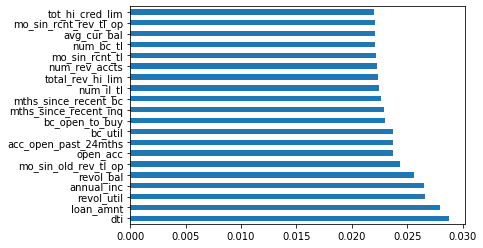

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# Correlation Matrix with Heatmap
Correlation states how the features are related to each other or the target variable.

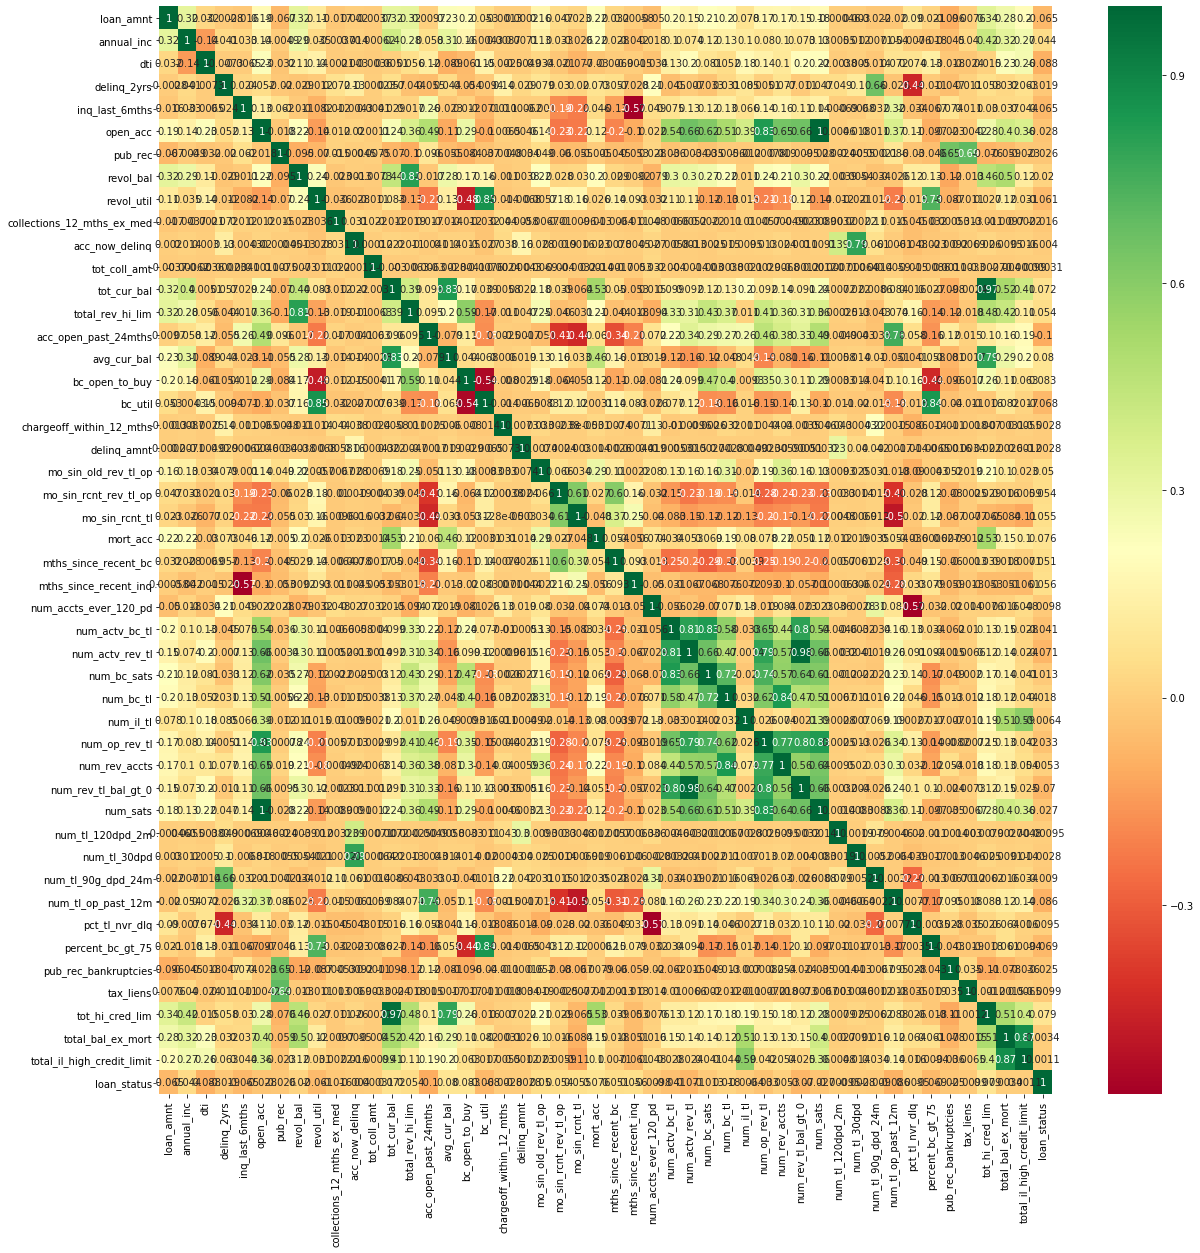

In [14]:
import seaborn as sns

#get correlations of each features in dataset
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Collinear Features
Collinear features are features that are highly correlated with one another. In machine learning, these lead to decreased generalization performance on the test set due to high variance and less model interpretability.

In [ ]:
# import featuretools as ft
# # Features are in train and labels are in train_labels
# fs = FeatureSelector(data = train, labels = train_labels)

In [ ]:
# # Collinear Features
# fs.identify_collinear(correlation_threshold = 0.98)
# fs.plot_collinear()
# # list of collinear features to remove
# collinear_features = fs.ops['collinear']
# # dataframe of collinear features
# fs.record_collinear.head()

# Zero Importence Features
The identify_zero_importance function finds features that have zero importance according to a gradient boosting machine (GBM) learning model.

In [ ]:
# # Pass in the appropriate parameters
# fs.identify_zero_importance(task = 'classification', 
#                             eval_metric = 'auc', 
#                             n_iterations = 10, 
#                              early_stopping = True)
# # list of zero importance features
# zero_importance_features = fs.ops['zero_importance']
# # plot the feature importances
# fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [ ]:
# fs.identify_low_importance(cumulative_importance = 0.99)
# fs.feature_importances.head(10)

# Single Unique Value Features
find any columns that have a single unique value. A feature with only one unique value cannot be useful for machine learning because this feature has zero variance. For example, a tree-based model can never make a split on a feature with only one value (since there are no groups to divide the observations into).

In [ ]:
# fs.identify_single_unique()
# fs.plot_unique()

In [ ]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds",format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target.values, y_pred, pos_label=1)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test)))

In [ ]:
cf1 = DecisionTreeClassifier()

cf3 = SVC()
cf2 = RandomForestClassifier(max_depth=2, random_state=0)
cf2 = RandomForestRegressor()

In [ ]:

rf = RandomForestClassifier(random_state = 42)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

# n_estimators = number of trees in the foreset
# max_features = max number of features considered for splitting a node
# max_depth = max number of levels in each decision tree
# min_samples_split = min number of data points placed in a node before the node is split
# min_samples_leaf = min number of data points allowed in a leaf node
# bootstrap = method for sampling data points (with or without replacement)
# Method of selecting samples for training each tree
#'max_features': ['auto'],
#'criterion' :['gini']


# Method of selecting samples for training each tree
# bootstrap = [True, False]

parameters = {
    # Number of trees in random forest
    'n_estimators'      : [350,400,450],
    # Maximum number of levels in tree
    'max_depth'         : [12, 18, 30, 48, 78],
    'random_state'      : [0],
    # Number of features to consider at every split
    'max_features': ['auto', 'sqrt'],
    # Minimum number of samples required to split a node
    'min_samples_split' : [2, 5, 10],
    # Minimum number of samples required at each leaf node
    'min_samples_leaf' : [1, 2, 4]

}



In [ ]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
fti = clf.feature_importances_
for i, feat in enumerate(X_train.columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

model = SelectFromModel(clf, prefit=True)
train_new = model.transform(X_train)

In [ ]:
clf = GridSearchCV(RandomForestClassifier(), parameters, cv=5, verbose=2, n_jobs=2)
clf.fit(train_new, y_train)

print(clf.score(train_new, y_train))
print(clf.best_params_)
print(zip(correct_train[predictor].columns, fti))

In [ ]:
##### # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# #rf_random = RandomizedSearchCV(estimator = rf, param_distributions = parameters, cv = 10, verbose=2, n_jobs = 2)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [ ]:
train_predict(cf2, X_train, y_train, X_val, y_val)

In [ ]:
y_pred = cf2.predict(X_test)

#predict_labels(clf, X_test, y_test)

In [ ]:
len(y_pred)

In [ ]:
loan = pd.DataFrame({'loan_status': y_pred[:]})

In [ ]:
#loan

In [ ]:
result = pd.concat([id_test,loan], axis=1, sort=False)

In [ ]:
#result

In [ ]:
result.to_csv('result.csv', index=False)